<a href="https://colab.research.google.com/github/arkincognito/PyTorch/blob/main/10_01_Pytorch_BasicCNN_for_MNIST_Multicore_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN(Convolutional Neural Network)

This notebook shows basic principals of CNN:
- What Convolution is
- Kernel Size
- Stride
- Padding
- Channel
- Pooling

## Convolution
Simply put, **Convolution** shows how well the image matches the filter.<br>
![Convolution](https://i.stack.imgur.com/4eMG8.png)<br>
Image above shows the behavior of a basic filter with the **Kernel Size** of 3 on $5\times5$ image.<br>
First $3\times3$ pixels of the image goes through convolution with the $3\times3$ filter.<br>
value for (1,1) of the feature map: $1\times1+1\times0+1\times1+...+0\times0+1\times1=4$<br>
Feature map gets filled up as the filter moves along the axes in the amount of the **Strides**.

##CNN Parameters
* Kernel Size(K): Size of the filter
* Stride(S): The amount of frames the filter move on the input
* Padding Size(P): Pad of zeros added around the border of the input. This provides control over output size.
* Channel Numbers(C): Number of filters applied to the input.

Output Size after a CNN Layer for $N\times N$ input:
$${N+2P-K\over S}+1$$
Number of Parameters in the CNN Layer:
$$channels\times (weights + bias) = C\times (K \times K + 1)$$

## Pooling
![Pooling Image](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)<br>
Non-linear down-sampling of CNN output.<br>
Pooling reduces the spatial size of the representation, reduces the number of parameters of the model, reducing the computational power required to train and evaluate the model, and provide the control over overfitting.

### Pytorch Code
Pytorch code example for basic CNN:<br>
```
layer1 = nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2)
)
```

Let's take a look at MNIST data and the CNN layer output.

MNIST image shape is 28 pixel height, 28 pixel width, 1 channel.
`transorms.ToTensor()` transforms MNIST image to tensors of 1 channel, 28 pixel height, 28 pixel width.

Output size of this $1\times28\times28$ tensor through a CNN layer with the following characteristics is:
* Kernel Size(K): 3
* Stride(S): 1
* Padding Size(P): 1
* Channel Numbers(C): 32

Output Size after a CNN Layer for $N\times N$ input:
$${28+2\times 1-3\over 1}+1 = 28$$

After a maxpool with filters of size $2\times2$, the output shape will be $14\times14$<br>

Let's check the calculation result with actual MNIST data.

In [ ]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
train_dataset = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=1,
      drop_last=True)

for batch in loader: #load 1 batch of MNIST Training data and check its shape
  data, label = batch
  print('MNIST data shape: ', data.shape)
  break

layer1 = nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1),#input_channel=1, output_channel=32
    nn.ReLU(),
    nn.MaxPool2d(2)
) # CNN Layer with K=3, S=1, P=1, C=32, Pooling_Kernel_Size=2
out1 = layer1(data)
print('First CNN Layer Output shape: ', out1.shape)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
MNIST data shape:  torch.Size([1, 1, 28, 28])
First CNN Layer Output shape:  torch.Size([1, 32, 14, 14])




We can see that the resulting data has 32 channels and $14\times 14$ shape.

## Fully Connected Layer
To classify an image, CNN layer output should go through a fully connected layer.<br>
Fully connected layer is a MLP layer we've been using before.

## Batch Normalization on CNN
We can apply `nn.BatchNorm2d` to apply batch normalization to CNN kernels.<br>


# Let's Code them

Enough with the theories.<br>
Let's start coding!<br>

## PyTorch/XLA preparation

As in [previous notebook]('https://colab.research.google.com/drive/1pBl22EzBXbaIBrO-lr8nkxnPGfCm-OLY#scrollTo=ej0qnTFC-p6m'), prepare Pytorch/XLA for Multi-Core TPU.


In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
# Installs PyTorch, PyTorch/XLA, and Torchvision
# Copy this cell into your own notebooks to use PyTorch on Cloud TPUs 
# Warning: this may take a couple minutes to run
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 39kB/s 
     |████████████████████████████████| 61kB 3.8MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import torch_xla.distributed.parallel_loader as pl
import time

## Model Classes

Here, we'll define 6 model classes.<br>

- CNN: 2 CNN layers and a fully connected layer.
- CNN_with_BN_in_CL_no_bias: CNN with Batch Normalization in convolution layer without bias in the kernels. Bias term in the kernel is redundant due to the $\beta$ in batch normalization for convolution layer.
- CNN_BN_in_CL_with_bias: CNN with Batch Normalization in convolution layer with bias in the kernels.
- CNN_BN_in_FC: CNN with Batch Normalization in FC layer
- CNN_BN_in_Both: CNN with Batch Normalization in both the convolution layer and the FC layer. Kernels don't have bias
- CNN_Dropout: CNN with dropout in FC layer

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1),#input_channel=1, output_channel=32
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),#input_channel=32, output_channel=64
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.ReLU(),
        self.linear2
    )
    
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

class CNN_BN_in_CL_no_bias(nn.Module):
  def __init__(self):
    super(CNN_BN_in_CL_no_bias, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1, bias=False),#Bias comes from beta in BN so no bias here.
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.ReLU(),
        self.linear2
    )
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

class CNN_BN_in_CL_with_bias(nn.Module):
  def __init__(self):
    super(CNN_BN_in_CL_with_bias, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1, bias=True),#Bias comes from beta in BN so no bias here.
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.ReLU(),
        self.linear2
    )
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

class CNN_BN_in_FC(nn.Module):
  def __init__(self):
    super(CNN_BN_in_FC, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1, bias=False),#Bias comes from beta in BN so no bias here.
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.BatchNorm1d(64),
        nn.ReLU(),
        self.linear2
    )
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

class CNN_BN_in_Both(nn.Module):
  def __init__(self):
    super(CNN_BN_in_Both, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1, bias=False),#Bias comes from beta in BN so no bias here.
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.BatchNorm1d(64),
        nn.ReLU(),
        self.linear2
    )
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

class CNN_Dropout(nn.Module):
  def __init__(self):
    super(CNN_Dropout, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1, bias=False),#Bias comes from beta in BN so no bias here.
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.ReLU(),
        nn.Dropout(p=FLAGS['drop_rate']),
        self.linear2
    )
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

## Trainer

We'll define TPU multicore trainer.<br>
This trainer will return `training_history` and `validation_history`, as well as the `data`, `target`, and `pred` as in prediction of the last batch of data.<br>
We'll use training history and validation history to visualize training progress and see when **Overfitting** happens.
Data, Target, and Prediction of the last batch will be used to visualize the prediction of the model.

In [ ]:
def train_model(net):
  ## Setup 
  # Sets a common random seed - both for initialization and ensuring graph is the same
  torch.manual_seed(FLAGS['seed'])
  ## Dataloader construction

  # Downloads train and test datasets
  # Note: master goes first and downloads the dataset only once (xm.rendezvous)
  #   all the other workers wait for the master to be done downloading.

  if not xm.is_master_ordinal():
    xm.rendezvous('download_only_once')

  train_dataset = datasets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

  test_dataset = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
  
  if xm.is_master_ordinal():
    xm.rendezvous('download_only_once')

  # Creates the (distributed) train sampler, which let this process only access
  # its portion of the training dataset.
  train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset,
    num_replicas=xm.xrt_world_size(),
    rank=xm.get_ordinal(),
    shuffle=True)
  
  # Creates dataloaders, which load data in batches
  # Note: test loader is not shuffled or sampled
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  
  ## Network, optimizer, and loss function creation
  # Acquires the (unique) Cloud TPU core corresponding to this process's index
  device = xm.xla_device()
  # Get model, loss function, and optimizer
  model = net.to(device)   
  loss_fn = torch.nn.CrossEntropyLoss()
  # Scale learning rate to world size
  lr = FLAGS['learning_rate'] * xm.xrt_world_size()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  def train_loop_fn(loader):
    model.train()
    batch_num_total = len(loader)
    training_loss = 0
    total_samples = 0
    num_correct = 0
    training_accuracy = 0
    for batch_num, (data, targets) in enumerate(loader):
      output = model(data)
      loss = loss_fn(output, targets)
      optimizer.zero_grad()
      loss.backward()
      xm.optimizer_step(optimizer)
      training_loss += loss / batch_num_total
      pred = output.max(1, keepdim=True)[1]
      num_correct += pred.eq(targets.view_as(pred)).sum().item()
      total_samples += data.size()[0]
    training_accuracy = 100.0 * num_correct / total_samples
    return training_accuracy, training_loss
        
  def test_loop_fn(loader):
    model.eval()
    batch_num_total = len(loader)
    total_samples = 0
    num_correct = 0
    validation_loss = 0
    for data, targets in loader:
      output = model(data)
      loss = loss_fn(output, targets)
      validation_loss += loss / batch_num_total
      pred = output.max(1, keepdim=True)[1]
      num_correct += pred.eq(targets.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    validation_accuracy = 100.0 * num_correct / total_samples
    return validation_accuracy, validation_loss, data, pred, targets

  # Train and eval loops
  training_history = []
  evaluating_history = []
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    training_accuracy, training_loss = train_loop_fn(para_loader.per_device_loader(device))

    para_loader = pl.ParallelLoader(test_loader, [device])
    validation_accuracy, validation_loss, data, pred, targets  = test_loop_fn(para_loader.per_device_loader(device))
    
    training_history.append(training_loss.tolist())
    evaluating_history.append(validation_loss.tolist())
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)
  return training_accuracy, training_history, validation_accuracy, evaluating_history, data, pred, targets

## Plot Helpers
First, import files to build plot helpers and set the font color and font size.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
%matplotlib inline
SMALL_SIZE = 10
MEDIUM_SIZE = 15
LARGE_SIZE = 18

plt.rc('font', size=SMALL_SIZE) # Default text sizes
plt.rc('axes', titlesize=LARGE_SIZE) # Axes title fontsize
plt.rc('axes', labelsize=MEDIUM_SIZE) # x and y labels' fontsize
plt.rc('xtick', labelsize=SMALL_SIZE) # x tick label size
plt.rc('ytick', labelsize=SMALL_SIZE) # y tick label size
plt.rc('legend', fontsize=SMALL_SIZE) # Legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE) # Figure title size

COLOR = 'white'
mpl.rcParams['text.color'] = 'black' # Default text color(including legend)
mpl.rcParams['axes.labelcolor'] = COLOR # Axes label color
mpl.rcParams['axes.titlecolor'] = COLOR # Subplot Title Color
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

### Prediction Visualization Helper

In [ ]:
# Result Visualization Helper
import math

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.png'

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(11, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.squeeze() # [1,Y,X] -> [Y,X]
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(prediction, color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(label, prediction), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

### Training History Visualization Helper

In [ ]:
import pandas as pd

def graph_history(TH_PATH, EH_PATH, net_names, ylim=(0,0.3), show_move_avg=True):  
  training_histories = pd.read_csv(TH_PATH, sep=',')
  evaluation_histories = pd.read_csv(EH_PATH, sep=',')
  fig = plt.figure(figsize=(15,8))
  tr_col_names = [net_name + '_train_loss' for net_name in net_names]
  ev_col_names = [net_name + '_eval_loss' for net_name in net_names] 
  tl_plot = sns.lineplot(data=training_histories[tr_col_names], dashes=[(2, 2) for _ in net_names], linewidth=2)
  el_plot = sns.lineplot(data=evaluation_histories[ev_col_names], dashes=False, linewidth=2)
  tl_plot.set(ylim=ylim)
  el_plot.set(ylim=ylim)
  if show_move_avg:
    moving_average_cols = []
    for net_name in ev_col_names:
      evaluation_histories[net_name + '_moving_average'] = evaluation_histories[net_name].rolling(5).mean().shift(-2)
      moving_average_cols.append(net_name + '_moving_average')
    el_average_plot = sns.lineplot(data=evaluation_histories[moving_average_cols], dashes=[(5, 2) for _ in moving_average_cols], linewidth=2)
    el_average_plot.set(ylim=ylim)
  plt.show()

### Training Process
Training histories will be saved into csv files.

In [ ]:
# Start training processes
def _mp_fn(rank, flags, NETS, NET_NAMES):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  training_histories = {}
  evaluation_histories = {}
  
  for net, net_name in zip(NETS, NET_NAMES):
    start_time = time.time()
    training_accuracy, training_history, validation_accuracy, evaluating_history, data, pred, targets = train_model(net)
    training_histories[net_name + '_train_loss'] = training_history
    evaluation_histories[net_name + '_eval_loss'] = evaluating_history
    if rank == 0:
      print(net_name, ' Training complete. Training Time: ', time.time() - start_time)
      print('Training Accuracy: ', training_accuracy, 'Validation Accuracy: ', validation_accuracy)
  if rank == 0:
    training_histories = pd.DataFrame(training_histories)
    evaluation_histories = pd.DataFrame(evaluation_histories)
    
    training_histories.to_csv(TH_PATH, sep=',', float_format = '%.6f')
    evaluation_histories.to_csv(EH_PATH, sep=',', float_format = '%.6f')

    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), targets.cpu())

## Component comparison

In [ ]:
# Configures training (and evaluation) parameters
FLAGS = {}
FLAGS['num_workers'] = 8
FLAGS['batch_size'] = 16
FLAGS['num_epochs'] = 10
FLAGS['seed'] = 0
FLAGS['learning_rate'] = 0.000125
FLAGS['num_cores'] = 8
FLAGS['metrics_debug'] = False
FLAGS['drop_rate'] = 0.5

cnn = CNN()
cnn_bn_in_cl_no_bias = CNN_BN_in_CL_no_bias()
cnn_bn_cl_with_bias = CNN_BN_in_CL_with_bias()
cnn_bn_in_fc = CNN_BN_in_FC()

cnn_bn_in_both = CNN_BN_in_Both()
cnn_dropout = CNN_Dropout()
NETS = [cnn, cnn_bn_in_cl_no_bias, cnn_bn_cl_with_bias, cnn_bn_in_fc, cnn_bn_in_both, cnn_dropout]
NET_NAMES = ['CNN', 'CNN_BN_in_CL_no_bias', 'CNN_BN_in_CL_with_bias','CNN_BN_in_FC', 'CNN_BN_in_Both', 'CNN_Dropout']


## Model Summary
`torchsummary.summary` summarizes the model, providing output shapes of each layer, parameter number in each layer, total number of parameters in the model, etc.<br>

In [ ]:
from torchsummary import summary
for net, net_name in zip(NETS, NET_NAMES):
  print(net_name, ' summary')
  summary(net, (1, 28, 28))

CNN  summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 64]         200,768
            Linear-8                   [-1, 64]         200,768
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
           Linear-11                   [-1, 10]             650
Total params: 421,652
Trainable params: 421,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 

We can see that
* Fully connected layer has more 

In [ ]:
TH_PATH = '/tmp/training_histories.csv'
EH_PATH = '/tmp/evaluation_histories.csv'

xmp.spawn(_mp_fn, args=(FLAGS, NETS, NET_NAMES), nprocs=FLAGS['num_cores'], start_method='fork')

CNN  Training complete. Training Time:  316.4635624885559
Training Accuracy:  99.73290598290598 Validation Accuracy:  98.98
CNN_BN_in_CL_no_bias  Training complete. Training Time:  437.5776264667511
Training Accuracy:  99.51923076923077 Validation Accuracy:  98.49
CNN_BN_in_CL_with_bias  Training complete. Training Time:  431.69555497169495
Training Accuracy:  99.59935897435898 Validation Accuracy:  98.43
CNN_BN_in_FC  Training complete. Training Time:  336.3408524990082
Training Accuracy:  99.86645299145299 Validation Accuracy:  99.13
CNN_BN_in_Both  Training complete. Training Time:  438.94810366630554
Training Accuracy:  99.83974358974359 Validation Accuracy:  99.0
CNN_Dropout  Training complete. Training Time:  329.6182780265808
Training Accuracy:  98.3573717948718 Validation Accuracy:  99.22


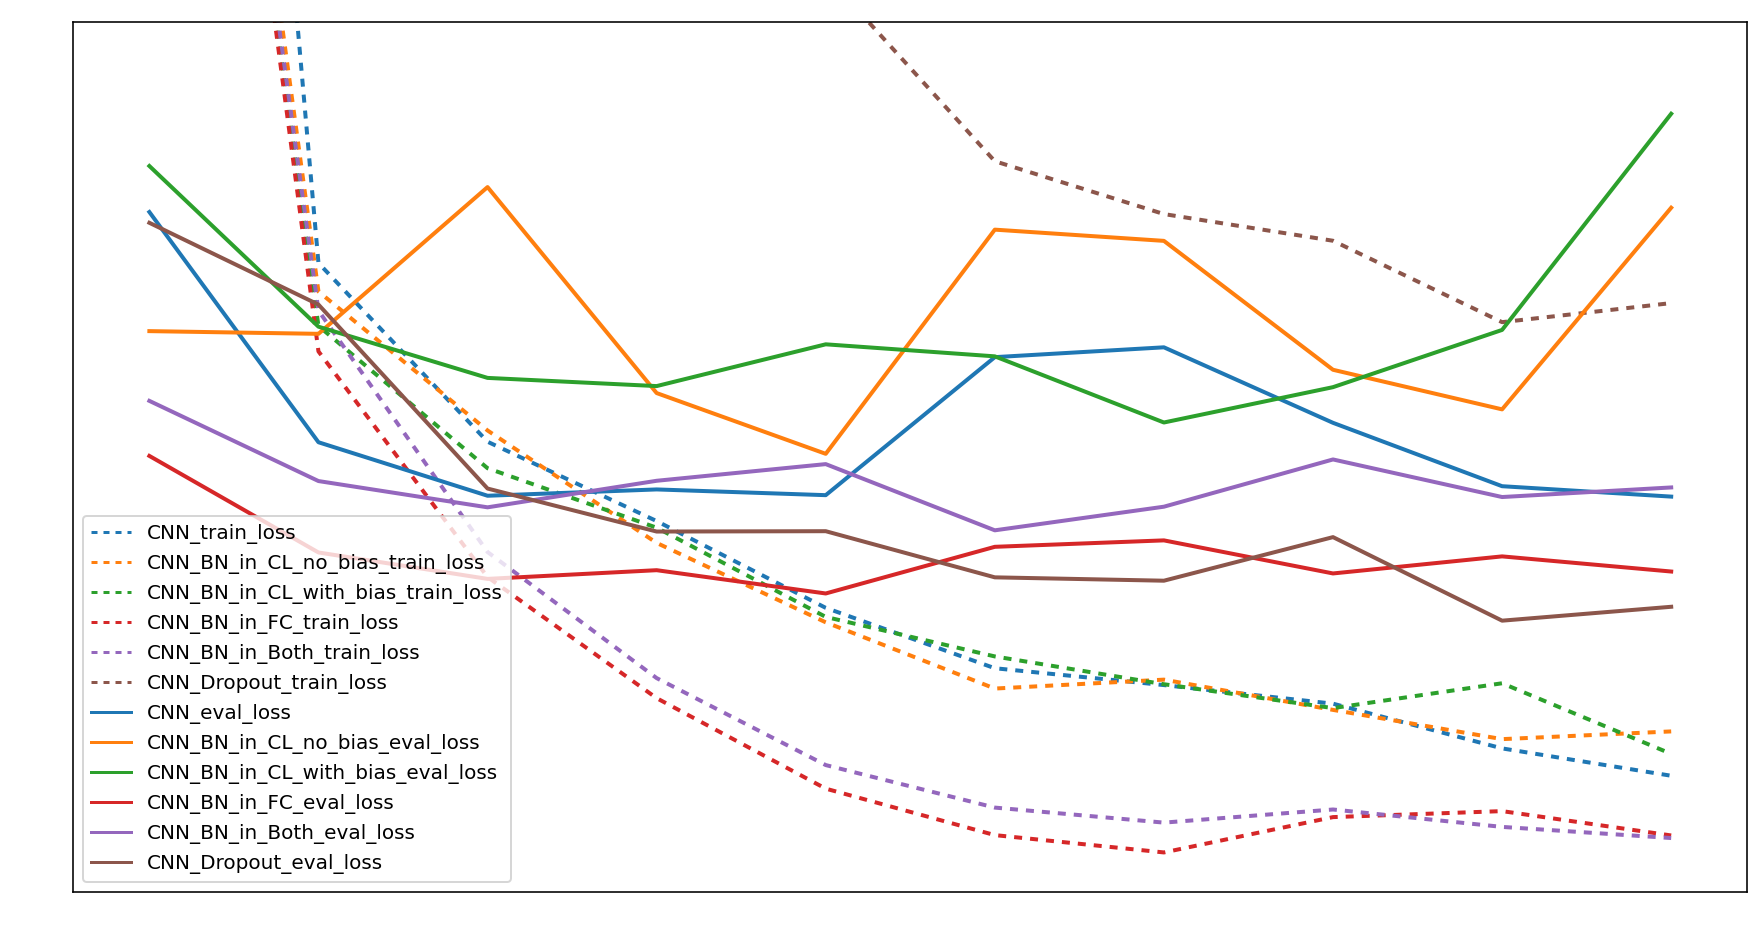

In [ ]:
graph_history(TH_PATH, EH_PATH, NET_NAMES, ylim=(0,0.08), show_move_avg=False)

## Results
**Batch normalization on convolution layer** doesn't show any improvement over the base model.<br>
<font color='#7F462C'> **`CNN_Dropout`**</font> and <font color='chilli pepper'>**`CNN_BN_in_FC`**</font> shows improvement as we've seen in MLP.<br>

## Final Net
Let's build a final model with batch normalization and dropout in the fc layer.

In [ ]:
class CNN_Final(nn.Module):
  def __init__(self):
    super(CNN_Final, self).__init__()
    self.linear1 = nn.Linear(7*7*64, 64, bias=True)
    self.linear2 = nn.Linear(64, 10, bias=True)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32, kernel_size=3, stride=1, padding=1, bias=False),#Bias comes from beta in BN so no bias here.
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc = nn.Sequential(
        self.linear1,
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=FLAGS['drop_rate']),
        self.linear2
    )
  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = output.view(output.size(0), -1)
    output = self.fc(output)
    return output

In [ ]:
cnn_final = CNN_Final()
NETS = [cnn_final]
NET_NAMES = ['CNN_Final']
TH_PATH = '/tmp/training_histories_final.csv'
EH_PATH = '/tmp/evaluation_histories_final.csv'

xmp.spawn(_mp_fn, args=(FLAGS, NETS, NET_NAMES), nprocs=FLAGS['num_cores'], start_method='fork')

CNN_Final  Training complete. Training Time:  357.8317394256592
Training Accuracy:  98.94497863247864 Validation Accuracy:  99.3


### Data Merge

In [ ]:
final_th = pd.read_csv('/tmp/training_histories_final.csv')
final_eh = pd.read_csv('/tmp/evaluation_histories_final.csv')

final_th = final_th.merge(pd.read_csv('/tmp/training_histories.csv')[['Unnamed: 0', 'CNN_train_loss', 'CNN_BN_in_CL_no_bias_train_loss', 'CNN_BN_in_CL_with_bias_train_loss','CNN_BN_in_FC_train_loss', 'CNN_BN_in_Both_train_loss', 'CNN_Dropout_train_loss']])
final_eh = final_eh.merge(pd.read_csv('/tmp/evaluation_histories.csv')[['Unnamed: 0', 'CNN_eval_loss', 'CNN_BN_in_CL_no_bias_eval_loss', 'CNN_BN_in_CL_with_bias_eval_loss','CNN_BN_in_FC_eval_loss', 'CNN_BN_in_Both_eval_loss', 'CNN_Dropout_eval_loss']])

TH_PATH = '/tmp/training_histories_fin.csv'
EH_PATH = '/tmp/evaluation_histories_fin.csv'

final_th.drop(columns=['Unnamed: 0'], inplace=True)
final_eh.drop(columns=['Unnamed: 0'], inplace=True)

final_th.to_csv(TH_PATH, sep=',', float_format = '%.6f')
final_eh.to_csv(EH_PATH, sep=',', float_format = '%.6f')

### Final Training Progress Evaluation

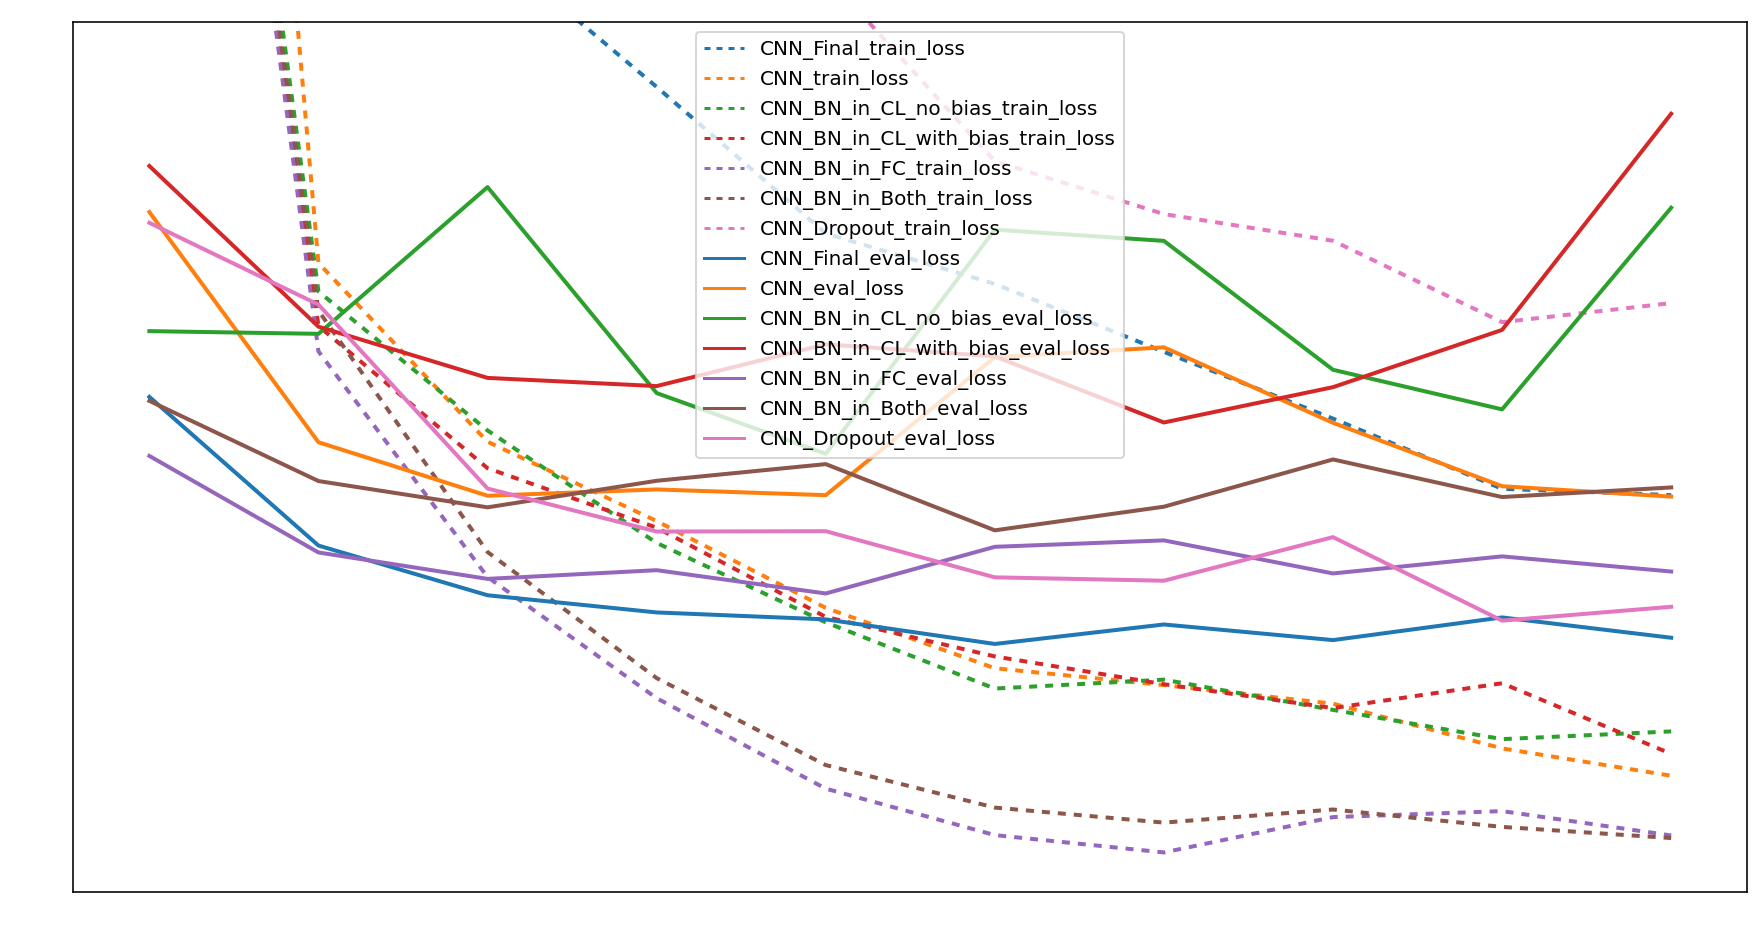

In [ ]:
NET_NAMES = ['CNN_Final', 'CNN', 'CNN_BN_in_CL_no_bias', 'CNN_BN_in_CL_with_bias','CNN_BN_in_FC', 'CNN_BN_in_Both', 'CNN_Dropout']
graph_history(TH_PATH, EH_PATH, NET_NAMES, ylim=(0,0.08), show_move_avg=False)

<font color='skyblue'>**`CNN_Final`**</font> shows the fastest **validation loss** decrease and shows less **overfitting** than the other nets.

## Prediction Visualization

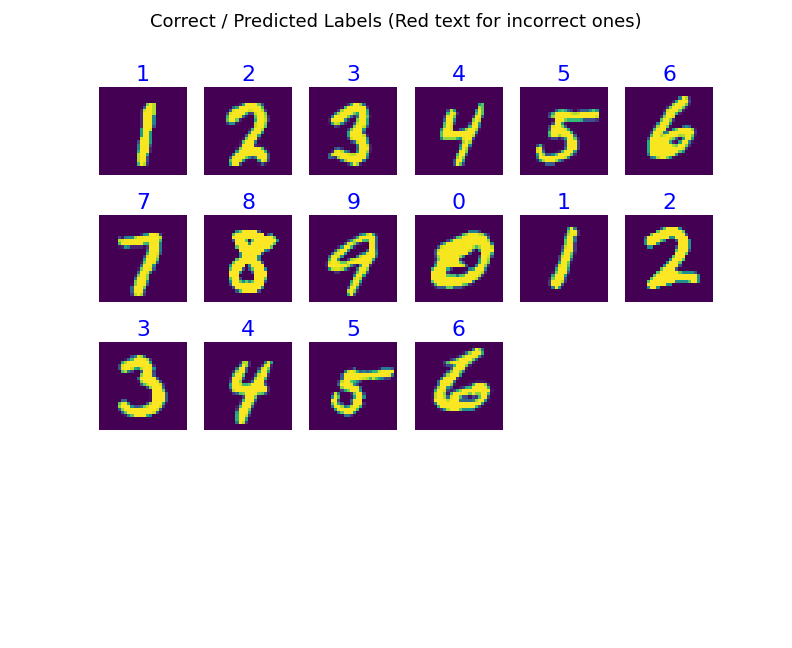

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)